# FTICR-MS Processing and Display

a simplified environment for processing 1D Bruker FTICR datasets with `SPIKE`

Run each python cell in sequence by using the ⇥Run button above (or typing *shift* Enter).

Cells are meant to be used in order, taking you to the complete analysis, but you can go back at any time.


### Initialization of the environment
the following cell should be run only once, at the beginning of the processing

## STARTING Environment...


          SPIKE
    Version     : 0.99.29
    Date        : 20-09-2021
    Revision Id : 529
*** zoom3D not loaded ***
plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 
plugins loaded:
msapmin, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin
plugins loaded:
Bruker_NMR_FT,  Bucketing,  Integrate,  PALMA,  apmin, 
plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 

Interactive module version, 1.2.1


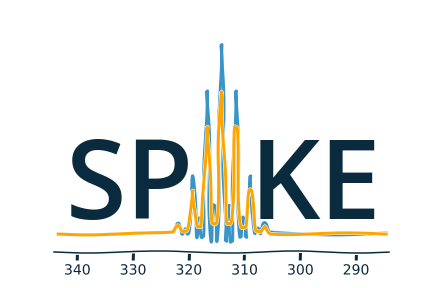

Run date: 2021-09-28T08:54:27.400671


## ...program is Ready

In [1]:
# load all python and interactive tools - has to be run only once (but it does not hurt to rerun...)
from IPython.display import display, HTML, Markdown, Image
display(Markdown('## STARTING Environment...'))
import matplotlib as mpl
%matplotlib widget
import os.path as op
import numpy as np
import pandas as pd
import spike
from spike.Interactive import INTER as I
from spike.Interactive import FTICR_INTER as FI
from spike.Interactive import MSIsotopic as ISO
from spike.Interactive.ipyfilechooser import FileChooser
from spike.File import BrukerMS
from datetime import datetime
I.initialize()
print('Run date:', datetime.now().isoformat() )
display(Markdown('## ...program is Ready'))
from importlib import reload  # this line is debugging help

# configurable items - you may change them to fit you preferences
verbose = 1                              # chose from 0 (terse) to 3 more verbose
mpl.rcParams['figure.figsize'] = (8,4)   # (X,Y) default figure size
I.Activate_Wheel = True                  # True/False    scale with wheel control in the graphic cells 

### Choose the file
The `FileChooser()` tool creates a dialog box which allows to choose a file on your disk

- use the `Select` button, click on the directory to move around `..` is for going back in the directory tree
- click on the file to select it
- modify the ( *optional* ) `path` argument, to start the exploration on a given location
- changing to `path='.'` will start the browsing from the current directory 
- After the selection, the selected filename is found in `FC.selected`

Bruker files are named `fid` and are contained in a `*.d` directory.

In [2]:
FC = FileChooser(path='/DATA', filetype='fid')
display(FC)

FileChooser(path='/DATA', filename='', show_hidden='False')

### Import dataset and display FID

This is simply done with the `Import_1D()` tool, which returns a `SPIKE` object.

We store the dataset into a variable, here called d1. 

In [4]:
# This is simply done with the `Import_1D()` tool, which returns a `SPIKE` object.
# We store it into a variable, evaluating the variable show a summary of the dataset. 
print('Reading file ',FC.selected)
d1 = BrukerMS.Import_1D(FC.selected)
d1.filename = FC.selected
d1.set_unit('sec').display(title=FC.selected_path+" transient")
d1

Reading file  /DATA/DATA/FT-ICR/M.Witt/Data for Marc Andre Delsuc April 2019/Asphaltene/APPI pos Sample D_000001.d/fid


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FTICR data-set
Bo: 14.00
Single Spectrum data-set
FT-ICR axis at 1428.571429 kHz,  8388608 real points,  from physical mz =  150.450   to m/z = 2000.000  R max (M=400) = 3155194

Spectra can be interactively explored with the jupyter tools displayed  on the side of the dataset:

- zoom with <button class="jupyter-matplotlib-button jupyter-widgets jupyter-button" href="#" title="Zoom to rectangle" style="outline: currentcolor none medium;"><i class="center fa fa-square-o"></i></button>
- shift and resize
<button class="jupyter-matplotlib-button jupyter-widgets jupyter-button" href="#" title="Pan axes with left mouse, zoom with right" style="outline: currentcolor none medium;"><i class="center fa fa-arrows"></i></button>
 (with left and right click)
- <button class="jupyter-matplotlib-button jupyter-widgets jupyter-button" href="#" title="Back to previous view" style="outline: currentcolor none medium;"><i class="center fa fa-arrow-left"></i></button>
and
<button class="jupyter-matplotlib-button jupyter-widgets jupyter-button" href="#" title="Forward to next view" style="outline: currentcolor none medium;"><i class="center fa fa-arrow-right"></i></button>
allow to navigate in the zoom history

- <button class="jupyter-matplotlib-button jupyter-widgets jupyter-button" href="#" title="Download plot" style="outline: currentcolor none medium;"><i class="center fa fa-fw fa-floppy-o"></i></button> is used to store a `png` graphic file of the current display.

The drawing zone can be resized using the little grey triangle on the lower-right corner



## Basic Processing
The following cell applies a basic processing, check the documentation for more advanced processing

### Compute Spectrum

many processing methods are available, they can be either applied one by one, or piped by chaining them.

Here we are chaining  apodisation - zerofill - FT - modulus

then setting to `m/z` unit (`Hz` and `points` also available) - finally `display()` is used to display the dataset.


In [4]:
D1 = d1.copy()                               # copy the imported data-set to another object for processing
D1.center().kaiser(4).zf(4)   # chaining  centering - apodisation - zerofill
                              # kaiser(4) is an apodisation well adapted to FTICR, slightly more resolution than hamming - try varying the argument !
if D1.axis1.itype == 0:       # means data is real (common case)
    D1.rfft().modulus()           # chaining  real FT - modulus
else:     # is 1              data is complex, in Narrow-band acquisition
    D1.fft().modulus()            # chaining  complex FT - modulus
D1.bcorr(xpoints=50)
D1.set_unit('m/z').display(title=FC.selected_path)  # set to ppm unit - and display

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

FTICR data-set
Bo: 14.00
Single Spectrum data-set
FT-ICR axis at 1428.571429 kHz,  16777216 real points,  from physical mz =  150.450   to m/z = 2000.000  R max (M=400) = 6310389

### Peak Detection
The following is used to perform an interactive peak picking, and output the result
Use the cursor to choose the sensitivity of the picker.

In [6]:
pkname = op.join(op.dirname(FC.selected),"peak_list.txt")
import spike.plugins.Peaks
print("number of on-screen peaks is limited to %d - zoom in with the top tool to be sure of visualizing them all"%(spike.plugins.Peaks.NbMaxDisplayPeaks))
FI.MSPeaker(D1, pkname);

number of on-screen peaks is limited to 1000 - zoom in with the top tool to be sure of visualizing them all


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Output(layout=Layout(border='1px solid red'))

## Superpose experimental and computed spectra

If the spectrum requires recalibration - eventually run the Calibration tool below, and rerun this tool.

In [9]:
from importlib import reload
reload(ISO)
IS = ISO.Isotope()
IS.full(D1)

Box(children=(Box(children=(Label(value='Enter formula:', layout=Layout(flex='3', width='auto')), Dropdown(lay…

---
### Calibration and reference peaks

The calibration used by SPIKE is based on a 2 or 3 parameters equation :
$$
f = \frac{A}{m/z} - B + \frac{C}{(m/z)^2}
$$
You can change them below.

For the moment you can recalibrate on a single reference peak, 
this modifies the first order $A$ parameter only.


In [7]:
reload(FI)
FI.Calib(D1);

### Save processed data
You can save a dataset, two formats are available:

- Native SPIKE format, `*.msh5` where all informations are stored - run the following cell

In [ ]:
msh5name = op.join(op.dirname(FC.selected),"SpikeProcessed.msh5")
D1.save_msh5(msh5name, compressed=True)
print("File is stored as %s"%msh5name)

- Or `cvs` format, with only the spectrum (for the peak list, see above) - ( *be carefull this file can be very big*)

In [ ]:
csvname = op.join(op.dirname(FC.selected),"SpikeProcessed.csv")
D1.save_csv(csvname)
print("File is stored as %s"%csvname)

### superimpose spectra
you can superimpose several spectra stored as `.msh5` files in order to compare them

In [22]:
reload(FI)
from IPython.display import display
SP = FI.SuperImpose(base='/DATA',N=3).Show()

Label(value='Select a file, and click on the Copy button to copy it to the chosen slot')

Button(button_style='info', description='Display', layout=Layout(width='10%'), style=ButtonStyle(), tooltip='d…

Output(layout=Layout(border='1px solid black'))

*the following cell display the colormap used here*

In [15]:
import matplotlib.pylab as plt
plt.figure()
for i ,c in enumerate(FI.Colors):
    plt.plot([0,1],[0,i],'-',color=c,label=c)
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …